In [4]:
"""
Dedalus script simulating 2D horizontally-periodic Rayleigh-Benard convection.
This script demonstrates solving a 2D Cartesian initial value problem. It can
be ran serially or in parallel, and uses the built-in analysis framework to save
data snapshots to HDF5 files. The `plot_snapshots.py` script can be used to
produce plots from the saved data. It should take about 5 cpu-minutes to run.

For incompressible hydro with two boundaries, we need two tau terms for each the
velocity and buoyancy. Here we choose to use a first-order formulation, putting
one tau term each on auxiliary first-order gradient variables and the others in
the PDE, and lifting them all to the first derivative basis. This formulation puts
a tau term in the divergence constraint, as required for this geometry.

To run and plot using e.g. 4 processes:
    $ mpiexec -n 4 python3 rayleigh_benard.py
    $ mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h5
"""


'\nDedalus script simulating 2D horizontally-periodic Rayleigh-Benard convection.\nThis script demonstrates solving a 2D Cartesian initial value problem. It can\nbe ran serially or in parallel, and uses the built-in analysis framework to save\ndata snapshots to HDF5 files. The `plot_snapshots.py` script can be used to\nproduce plots from the saved data. It should take about 5 cpu-minutes to run.\n\nFor incompressible hydro with two boundaries, we need two tau terms for each the\nvelocity and buoyancy. Here we choose to use a first-order formulation, putting\none tau term each on auxiliary first-order gradient variables and the others in\nthe PDE, and lifting them all to the first derivative basis. This formulation puts\na tau term in the divergence constraint, as required for this geometry.\n\nTo run and plot using e.g. 4 processes:\n    $ mpiexec -n 4 python3 rayleigh_benard.py\n    $ mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h5\n'

In [1]:
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import copy
import h5py
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from dedalus.extras import plot_tools
import os
from os import listdir


In [6]:
matplotlib.use('Agg')

In [2]:
# Parameters
Lx, Lz = 4,1
Nx, Nz = 256, 64

Ra_D = 1.24e5
Ra_BV = 2e5
Prandtl = 1

D_0 = 0.2
D_H = 0
M_0 = 0
M_H = -1

dealias = 3/2
stop_sim_time = 50
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

In [3]:
# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

In [4]:
# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
D = dist.Field(name='D', bases=(xbasis,zbasis))
M = dist.Field(name='M', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
Z = dist.Field(name='Z', bases=zbasis)
tau_p = dist.Field(name='tau_p')
tau_B1 = dist.Field(name='tau_B1', bases=xbasis)
tau_B2 = dist.Field(name='tau_B2', bases=xbasis)
tau_D1 = dist.Field(name='tau_D1', bases=xbasis)
tau_D2 = dist.Field(name='tau_D2', bases=xbasis)
tau_M1 = dist.Field(name='tau_M1', bases=xbasis)
tau_M2 = dist.Field(name='tau_M2', bases=xbasis)
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)

# Substitutions
kappa = (Ra_D * Prandtl/((D_0-D_H)*Lz**3))**(-1/2)
nu = (Ra_D / (Prandtl*(D_0-D_H)*Lz**3))**(-1/2)

      
#Kuo_Bretherton Equilibrium

#Ra_M
Ra_M = Ra_D*(M_0-M_H)/(D_0-D_H)
G_D=(D_0-D_H)/Lz
G_M=(M_0-M_H)/Lz
N_s2=Ra_BV*nu*kappa/Lz**4
print(Ra_M)
print(N_s2)

x,z = dist.local_grids(xbasis,zbasis)
Z['g']=z
Z.change_scales(3/2)

ex,ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

B_op = (np.absolute(D - M - N_s2*Z)+ M + D - N_s2*Z)/2

Max = lambda A,B: (abs(A-N_s2*Z-B)+A-N_s2*Z+B)/2
eva = lambda A: A.evaluate()

uz = u@ez

grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_M = d3.grad(M) + ez*lift(tau_M1) # First-order reduction
grad_D = d3.grad(D) + ez*lift(tau_D1) # First-order reduction

620000.0
0.32258064516129026


In [10]:
# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, M, D, u, tau_p, tau_M1, tau_M2, tau_D1, tau_D2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p= 0")
problem.add_equation("dt(M) - kappa*div(grad_M) + lift(tau_M2) - G_M*uz= - u@grad(M)")
problem.add_equation("dt(D) - kappa*div(grad_D) + lift(tau_D2) - G_D*uz= - u@grad(D)")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p)  + lift(tau_u2) = - u@grad(u)+ B_op*ez")
problem.add_equation("M(z=0) = M_0")
problem.add_equation("D(z=0) = D_0")
problem.add_equation("u(z=0) = 0")
problem.add_equation("M(z=Lz) = M_H")
problem.add_equation("D(z=Lz) = D_H")
problem.add_equation("u(z=Lz)= 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

{'LHS': Integrate(Integrate(<Field 5293993808>)),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.float64,
 'M': 0,
 'L': Integrate(Integrate(<Field 5293993808>)),
 'F': <Field 5285178768>,
 'domain': <dedalus.core.domain.Domain at 0x13bb4ba10>,
 'matrix_dependence': array([ True,  True]),
 'matrix_coupling': array([False,  True])}

In [12]:
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time


2023-06-23 15:52:04,125 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 6s, Rate: 2.0e+01/s
2023-06-23 15:52:04,566 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 2.7e+01/s
2023-06-23 15:52:05,059 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 1s, Remaining: 4s, Rate: 2.6e+01/s
2023-06-23 15:52:05,584 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 2s, Remaining: 3s, Rate: 2.6e+01/s
2023-06-23 15:52:06,088 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 2s, Remaining: 3s, Rate: 2.6e+01/s
2023-06-23 15:52:06,606 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 3s, Remaining: 2s, Rate: 2.6e+01/s
2023-06-23 15:52:07,204 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 3s, Remaining: 2s, Rate: 2.5e+01/s
2023-06-23 15:52:07,719 subsystems 0/1 INFO :: Building subprobl

In [ ]:
# Initial condition
D.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
D['g'] *= z * (Lz - z) # Damp noise at walls
D['g'] += Lz - z # Add linear background
M.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
M['g'] *= z * (Lz - z) # Damp noise at walls
M['g'] += Lz - z # Add linear background

In [ ]:
# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=0.25, max_writes=50)
snapshots.add_task(M, name='moist buoyancy')
snapshots.add_task(D, name='dry buoyancy')
snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')

In [ ]:
# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

In [ ]:
# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')


In [ ]:
# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2023-06-23 15:31:00,068 __main__ 0/1 INFO :: Starting main loop
2023-06-23 15:31:00,429 __main__ 0/1 INFO :: Iteration=861, Time=1.657022e+01, dt=1.243896e-02, max(Re)=453.238982
2023-06-23 15:31:00,772 __main__ 0/1 INFO :: Iteration=871, Time=1.669461e+01, dt=1.243896e-02, max(Re)=457.162972
2023-06-23 15:31:01,150 __main__ 0/1 INFO :: Iteration=881, Time=1.681900e+01, dt=1.243896e-02, max(Re)=460.043777
2023-06-23 15:31:01,512 __main__ 0/1 INFO :: Iteration=891, Time=1.694339e+01, dt=1.243896e-02, max(Re)=456.978279
2023-06-23 15:31:01,878 __main__ 0/1 INFO :: Iteration=901, Time=1.706778e+01, dt=1.243896e-02, max(Re)=456.493726
2023-06-23 15:31:02,223 __main__ 0/1 INFO :: Iteration=911, Time=1.719217e+01, dt=1.243896e-02, max(Re)=455.054682
2023-06-23 15:31:02,570 __main__ 0/1 INFO :: Iteration=921, Time=1.731656e+01, dt=1.243896e-02, max(Re)=459.485632
2023-06-23 15:31:02,912 __main__ 0/1 INFO :: Iteration=931, Time=1.744095e+01, dt=1.243896e-02, max(Re)=479.048938
2023-06-23 15:31

In [5]:
folder_dir = "snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
file_paths.sort()
print(file_paths)

['snapshots/snapshots_s1.h5', 'snapshots/snapshots_s2.h5', 'snapshots/snapshots_s3.h5', 'snapshots/snapshots_s4.h5']


In [ ]:
n=0

# Plot settings
tasks = ['moist buoyancy', 'dry buoyancy', 'vorticity']
scale = 1.5
dpi = 200
title_func = lambda sim_time: 't = {:.3f}'.format(sim_time)
savename_func = lambda write: 'write_{:06}.png'.format(write)

# Layout
nrows, ncols = 2, 2
image = plot_tools.Box(4, 1)
pad = plot_tools.Frame(0.3, 0, 0, 0)
margin = plot_tools.Frame(0.2, 0.1, 0, 0)

# Create multifigure
mfig = plot_tools.MultiFigure(nrows, ncols, image, pad, margin, scale)
fig = mfig.figure


for file in file_paths:
    with h5py.File(file, mode='r') as file:
        
            b = file['tasks']['buoyancy']
            st = file['scales/sim_time']
            xgrid = b.dims[1][0][:]
            zgrid = b.dims[3][0][:]
            xorder = np.argsort(xgrid)
            zorder = np.argsort(zgrid)
            xmesh, zmesh = quad_mesh(xgrid[xorder], zgrid[zorder])
            # Plot data
            for t in range(50):
                b_phase=b[t,:,y_slice_afterscale,:]
                b_phasef=np.transpose(b_phase)
                plt.figure(figsize=(20,5), dpi=200)
                plt.pcolormesh(xmesh, zmesh, b_phasef, shading='Auto', cmap='RdBu_r')
                plt.tick_params(length=0, width=0)
                plt.colorbar(label='buoyancy')
                plt.xlabel('x')
                plt.ylabel('z')

                # Add time title
                title = "t="+str(st[t])
                plt.title(title)
                # Save figure
                savename = "Plot_"+"%04d"%n+".png"
                savepath = 'frames/'+savename
                n=n+1
                plt.savefig(str(savepath), dpi=200,bbox_inches='tight')
                matplotlib.pyplot.close()

In [24]:
n=0
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        moistbuoyancy = file['tasks']['moist buoyancy']
        drybuoyancy = file['tasks']['dry buoyancy']
        buoyancy=np.maximum(moistbuoyancy,drybuoyancy-N_s2*z)
        st = file['scales/sim_time']
        for t in range(50):
            mb = np.transpose(moistbuoyancy[t,:,:])
            db = np.transpose(drybuoyancy[t,:,:])
            bu = np.transpose(buoyancy[t,:,:])
            plt.contourf(bu, cmap='RdBu_r')
            plt.colorbar(label='buoyancy')
            plt.xlabel('x')
            plt.ylabel('z')
            n=n+1
            # Add time title
            title = "t="+str(st[t])
            plt.title(title)
            plt.savefig('buoyancygraph/buoyancy_'+"%04d"%n+'.png', dpi=200,bbox_inches='tight')
            matplotlib.pyplot.close()
            


2023-06-24 01:09:42,904 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-06-24 01:09:42,907 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3200x800 -pix_fmt rgba -r 4.0 -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y buoyancygraph.gif


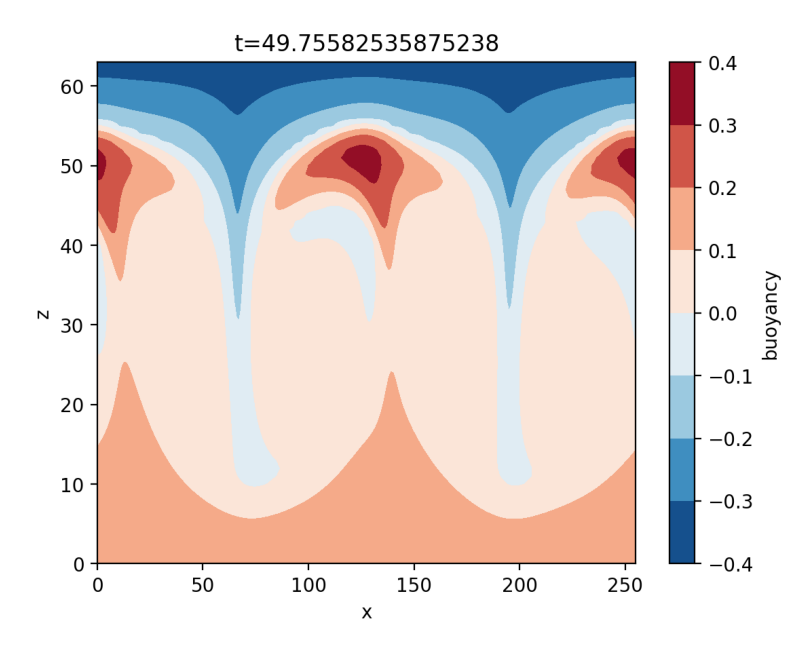

In [25]:
import matplotlib.animation as Animation
from PIL import Image


folder_dir = 'buoyancygraph'

# Get a list of PNG file paths from the directory
file_paths = [os.path.join(folder_dir, f) for f in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, f)) and f.endswith('.png')]

# Sort the list of file paths
file_paths.sort()

# Read the images using PIL
imgs = [Image.open(f) for f in file_paths]

fig = plt.figure(figsize=(16,4),dpi=200)
fig.patch.set_visible(False)
plt.axis('off')

# Wrap each image in a list to create a list of sequences of artists
imgs = [[plt.imshow(img, animated=True)] for img in imgs]

ani = Animation.ArtistAnimation(fig, imgs, interval=250, blit=True, repeat_delay=1000)

# Save the animation to a file
ani.save('buoyancygraph.gif',dpi=200)


In [9]:
os.mkdir('liquid water')
n=0
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        moistbuoyancy = file['tasks']['moist buoyancy']
        drybuoyancy = file['tasks']['dry buoyancy']
        ql=np.maximum(moistbuoyancy[:]-drybuoyancy[:]+N_s2*z,0)
        st = file['scales/sim_time']
        for t in range(50):
            qli=np.transpose(ql[t,:,:])
            plt.contourf(qli, cmap='RdBu_r')
            plt.colorbar(label='liquid water')
            plt.xlabel('x')
            plt.ylabel('z')
            n=n+1
            # Add time title
            title = "t="+str(st[t])
            plt.title(title)
            plt.savefig('liquid water/liquidwater_'+"%04d"%n+'.png', dpi=200,bbox_inches='tight')
            matplotlib.pyplot.close()

2023-06-24 11:37:03,094 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-06-24 11:37:03,095 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3200x800 -pix_fmt rgba -r 4.0 -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y liquidwater.gif


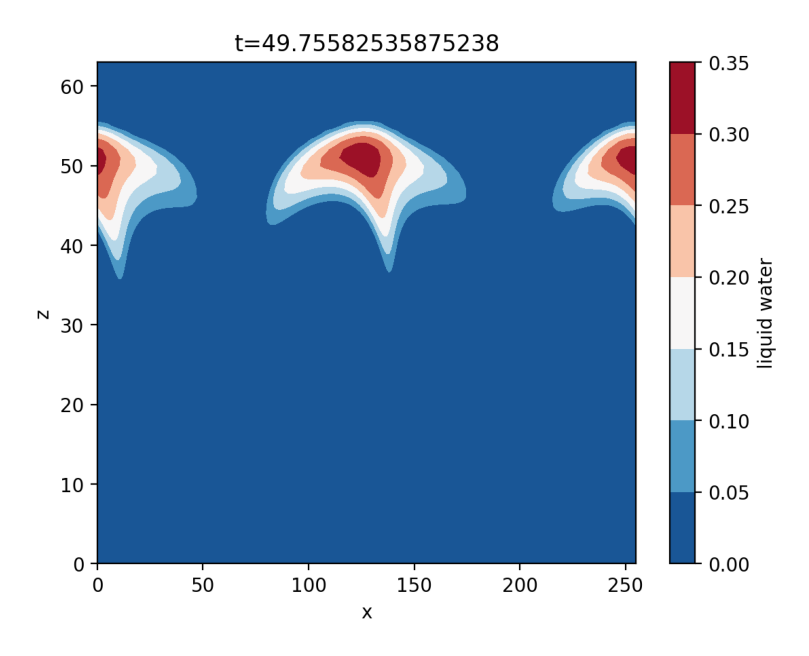

In [10]:
import matplotlib.animation as Animation
from PIL import Image


folder_dir = 'liquid water'

# Get a list of PNG file paths from the directory
file_paths = [os.path.join(folder_dir, f) for f in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, f)) and f.endswith('.png')]

# Sort the list of file paths
file_paths.sort()

# Read the images using PIL
imgs = [Image.open(f) for f in file_paths]

fig = plt.figure(figsize=(16,4),dpi=200)
fig.patch.set_visible(False)
plt.axis('off')

# Wrap each image in a list to create a list of sequences of artists
imgs = [[plt.imshow(img, animated=True)] for img in imgs]

ani = Animation.ArtistAnimation(fig, imgs, interval=250, blit=True, repeat_delay=1000)

# Save the animation to a file
ani.save('liquidwater.gif',dpi=200)